In [35]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import math
%matplotlib inline

### Curvas

In [36]:
#Read Databases
curva_mxn = pd.read_csv('https://raw.githubusercontent.com/zaygb/Derivados/main/CURVAMXN.csv')


### Manipulación de tablas
Se reordenan las tablas para poder realizar los calculos (solo correr codigo)

In [37]:
#Unpivot Tablas de Curvas
curvas = curva_mxn.melt(id_vars='Node',var_name='Dates', value_name='Valor')
curvas['Dates'] = pd.to_datetime(curvas['Dates'], format= '%d/%m/%Y')

### Función para crear data frame con los días del contrato

In [38]:
def crear_dataframe_fechas(fecha_inicio, num_dias):
    # Convierte la fecha de inicio en un objeto datetime
    fecha_inicio = datetime.strptime(fecha_inicio, '%d/%m/%Y')
    
    # Crea una lista de fechas diarias
    fechas = [fecha_inicio + timedelta(days=i) for i in range(num_dias)]
    
    # Crea un DataFrame con la lista de fechas
    df = pd.DataFrame({'Dates': fechas})
    
    return df

### Función para calcular el valor presente de la parte fija de un Swap

In [39]:
def swap_fija(curvas,today,apertura_fecha,pago_cada,vencimiento_dias,payment_per_year,nocional,c):
    #today = datetime.strptime(today, '%d/%m/%Y')
    apertura_fecha = datetime.strptime(apertura_fecha, '%d/%m/%Y')
    dias_devengados = (today - apertura_fecha).days
    dias_faltantes = vencimiento_dias - dias_devengados
    # Calcular hace cuanto fue la ultima fecha cupón
    residuo = dias_devengados % pago_cada
    # Cuantos días faltan hasta el proximo pago
    inicio_nodo = pago_cada - residuo
    # Crear data frame con los nodos de los pagos que faltan
    secuencia_nodos = list(range(inicio_nodo,dias_faltantes+1,pago_cada))
    tabla_swap = pd.DataFrame({'Node': secuencia_nodos})
    # Agregar t y los valores de la curva del día de hoy
    tabla_swap['t'] = tabla_swap['Node']/360
    curva_today = curvas[curvas['Dates']==today]
    tabla_swap = tabla_swap.merge(curva_today, on = 'Node', how = 'left')
    # Factor de Descuento
    tabla_swap['FD'] = 1/(1+(tabla_swap['Valor']*tabla_swap['t']))
    # Calcular el pago fijo (misma para todas las fecha cupon)
    tabla_swap['Fija'] = c*(1/payment_per_year)*nocional
    # Recalcular el ultimo pago sumandole el nocional
    tabla_swap.loc[tabla_swap.index[-1], 'Fija'] = (c*(1/payment_per_year)*nocional) + nocional
    # Traer todos los pagos a valor presente
    valor_presente = (tabla_swap['FD'] * tabla_swap['Fija']).sum()
    return valor_presente

### Función para calcular el valor presente de la parte variable de un Swap

In [40]:
def swap_var(curvas,today,apertura_fecha,pago_cada,payment_per_year,nocional):
    apertura_fecha = datetime.strptime(apertura_fecha, '%d/%m/%Y')
    dias_devengados = (today - apertura_fecha).days
    # Calcular cuantos días pasaron desde el ultimo pago
    residuo = dias_devengados % pago_cada
    # Calcular la fecha de ese ultimo pago
    fecha_ultimo_cupon = today - timedelta(days=residuo)
    # Si estamos en fecha cupon (día de pago) el valor de los flujos presentes es el nocional, si no es día de pago se le suma el nocional + lo correspondiente al periodo
    if residuo == 0:
        valor_presente = nocional
    else:
        # Curva del ultimo día de pago a los días que se paga el bono
        curva_ultimo_cupon = curvas[(curvas['Node'] == pago_cada) & (curvas['Dates'] == fecha_ultimo_cupon)].reset_index(drop=True)
        valor_ultimo_cupon = curva_ultimo_cupon.loc[0,'Valor']
        Variable = (valor_ultimo_cupon * (1/payment_per_year) * nocional) + nocional   
        # Cuanto falta para el proximo pago
        Nodo = pago_cada - residuo
        # Curva de hoy
        curva_hoy = curvas[(curvas['Node'] == Nodo) & (curvas['Dates'] == today)].reset_index(drop=True)
        valor_hoy = curva_hoy.loc[0,'Valor']
        t = Nodo/360
        # Factor de descuento
        FD = 1/(1+(valor_hoy*t))
        # Traer a valor presente
        valor_presente = FD * Variable
    return valor_presente
    


### Función para Calcular el valor diario de un swap

In [41]:
def daily_swap_value(curvas,apertura_fecha,vencimiento_dias,pago_cada,nocional,c,tasa_recibes):
    payment_per_year = 360/pago_cada

    swap = crear_dataframe_fechas(apertura_fecha,vencimiento_dias)
    swap = swap.merge(curvas['Dates'].drop_duplicates(), on='Dates', how='inner')
    swap['Fija'] = swap.apply(lambda row: swap_fija(curvas,row['Dates'],apertura_fecha,pago_cada,vencimiento_dias,payment_per_year,nocional,c), axis=1)
    swap['Variable'] = swap.apply(lambda row: swap_var(curvas,row['Dates'],apertura_fecha,pago_cada,payment_per_year,nocional), axis=1)
    if tasa_recibes == 'variable': 
        swap['Valor del Swap'] = swap['Variable'] - swap['Fija']
    else: 
        swap['Valor del Swap'] = swap['Fija'] - swap['Variable']
    
    return swap


## Graficas

### Contrato 1
* nocional = 1000000
* vencimiento_dias = 364
* pago_cada = 28
* apertura_fecha = '03/01/2022'
* tasa_recibes = 'variable'
* c = 0.0672814237354334

In [42]:
Contrato1 = daily_swap_value(curvas,'03/01/2022',364,28,1000000,0.0672814237354334,'variable')
Contrato1 = Contrato1.set_index('Dates')


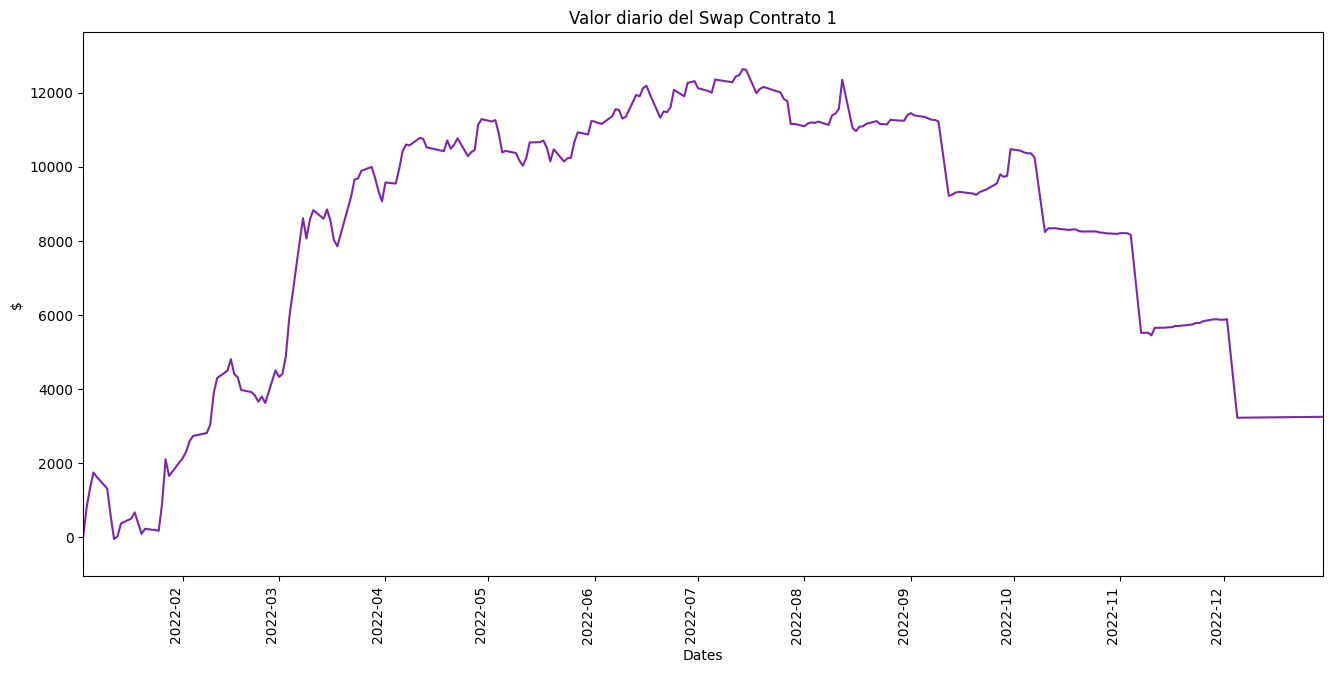

In [44]:
plt.figure(figsize=(16, 8))
Contrato1['Valor del Swap'].plot.line(color= '#7e25af')
plt.xlabel('Dates')
plt.ylabel('$')
plt.title('Valor diario del Swap Contrato 1')
max_ylim = max(Contrato1['Valor del Swap'])+1000
min_ylim = min(Contrato1['Valor del Swap'])-1000
plt.ylim(min_ylim,max_ylim)
plt.xlim(Contrato1.index.min(), Contrato1.index.max())
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()

### Contrato 2
* nocional = 1000000
* vencimiento_dias = 728
* pago_cada = 28
* apertura_fecha = '03/01/2022'
* tasa_recibes = 'variable'
* c = 0.0709708281362001

In [45]:
Contrato2 = daily_swap_value(curvas,'03/01/2022',728,28,1000000,0.0709708281362001,'variable')
Contrato2 = Contrato2.set_index('Dates')

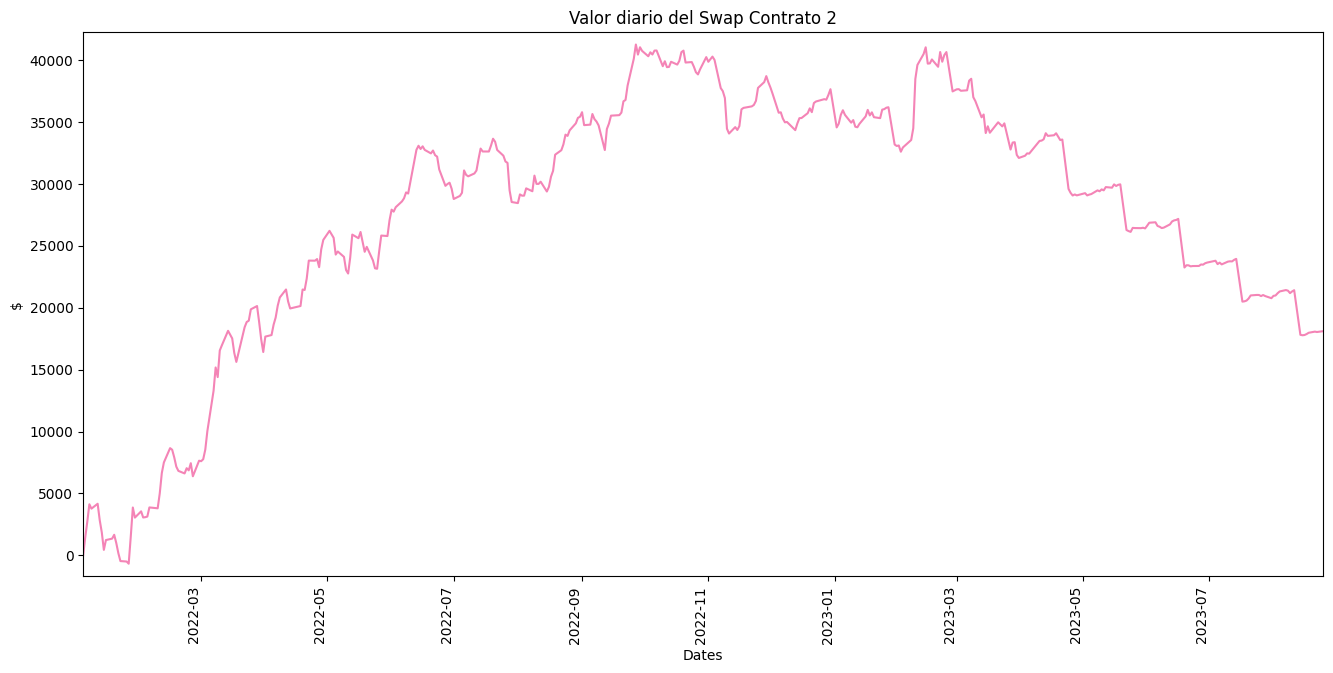

In [49]:
plt.figure(figsize=(16, 8))
Contrato2['Valor del Swap'].plot.line(color= '#f484b6')
plt.xlabel('Dates')
plt.ylabel('$')
plt.title('Valor diario del Swap Contrato 2')
max_ylim = max(Contrato2['Valor del Swap'])+1000
min_ylim = min(Contrato2['Valor del Swap'])-1000
plt.ylim(min_ylim,max_ylim)
plt.xlim(Contrato2.index.min(), Contrato2.index.max())
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()


### Contrato 3
* nocional = 1000000
* vencimiento_dias = 364
* pago_cada = 28
* apertura_fecha = '03/01/2022'
* tasa_recibes = 'fija'
* c = 0.0672814237354334

In [47]:
Contrato3 = daily_swap_value(curvas,'03/01/2022',364,28,1000000,0.0672814237354334,'fija')
Contrato3 = Contrato3.set_index('Dates')

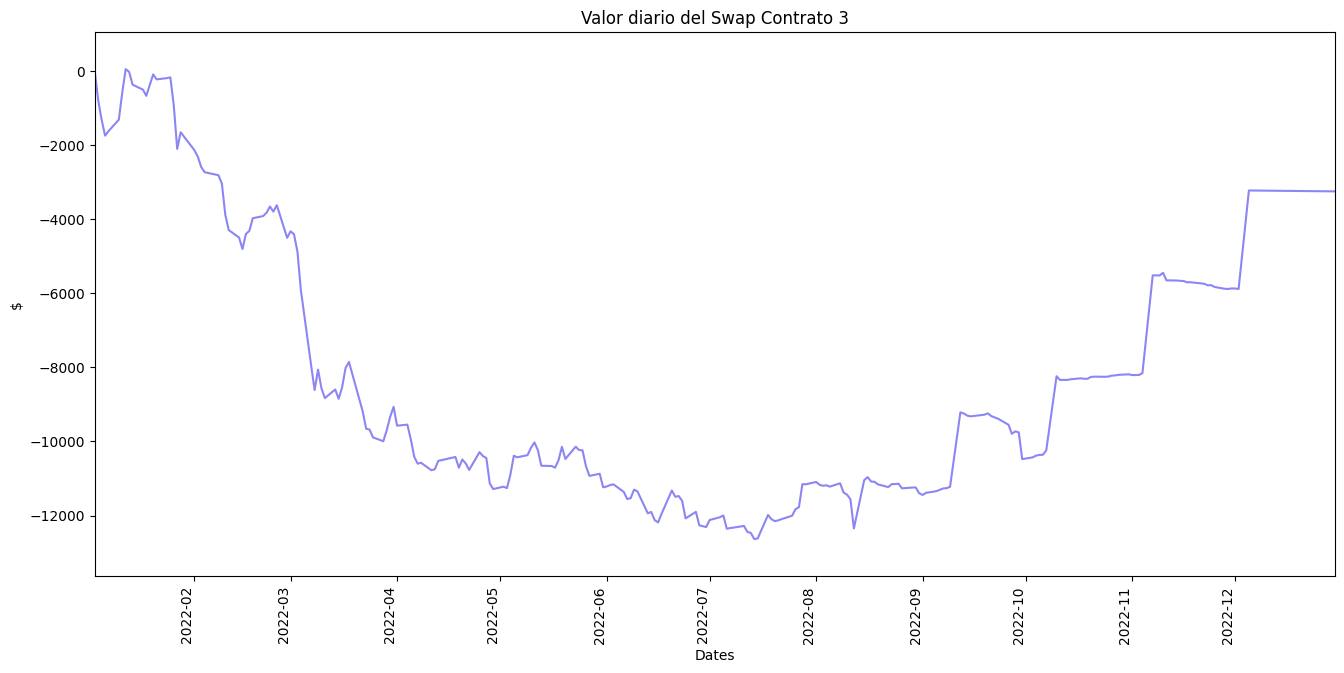

In [50]:
plt.figure(figsize=(16, 8))
Contrato3['Valor del Swap'].plot.line(color= '#8c85f4')
plt.xlabel('Dates')
plt.ylabel('$')
plt.title('Valor diario del Swap Contrato 3')
max_ylim = max(Contrato3['Valor del Swap'])+1000
min_ylim = min(Contrato3['Valor del Swap'])-1000
plt.ylim(min_ylim,max_ylim)
plt.xlim(Contrato3.index.min(), Contrato3.index.max())
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()